# Libraries

In [200]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from utils_soundfields import plot_sf, plot_rir
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# import matplotlib.gridspec as gridspec
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.ticker
# from sklearn.model_selection import train_test_split
from icecream import ic
import numpy as np
import time
# import scipy.io
import pandas as pd

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cpu


# Tunning Parameters

plot_rir# Problem Setup
https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks

**2D Wave Equation**

$$\frac{\partial^2 p}{\partial t^2} = c^2 \left( \frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} \right) \rightarrow$$
$$\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2}  - \frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} = 0$$

$$x, y \in[-1,1]$$
$$t\in[0,1]$$


# Inverse Problems

**Forward Problem**: Model$→$Data (Predict)

**Inverse Problem**: Data→Model (i.e., actually, we get the Model's parameters)

###Example

(See: https://book.sciml.ai/notes/10/)

A Neural Network is an example of an inverse problem:

1.   We have an unknown model that follows:

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

2.   We use our "training" data to get $W_i$ and $b_i$; for $i=1,2,..\#layers$.


Specifically:

Data → Model i.e., estimate our model parameters (i,e., $W_i$ and $b_i$)




# PINNs for Inverse Problems or "Data-driven Discovery of Nonlinear Partial Differential Equations"

(See: https://arxiv.org/abs/1711.10566)

**Inverse Problem**: Data$→$Model's parameters so:

Data →PINN→ Model Parameters (i.e., our PDE parameters)

For parameterized and nonlinear partial differential equations of the general form (Raissi et al., 2017):

$$p_{tt}+\mathscr{N}[p; c]=0$$

where, $p(\mathbf{r},t)$ is the hidden solution and $\mathscr{N}[p;c]$ is a nonlinear operator.

In short: We will use a PINN to get $p(\mathbf{r}^{\prime},t)$ in positions $\mathbf{r}^{\prime}$.


## Analysis:

Let:

$p_{tt}=\frac{\partial^2 p}{\partial t^2}$

$p_{xx}=\frac{\partial^2 u}{\partial x^2}$
$p_{yy}=\frac{\partial^2 u}{\partial y^2}$

$\mathscr{N}[p;c]=c^2 \left( p_{xx} + p_{yy} \right)$

Our PDE is described as:

$$p_{tt} - c^2 \left( p_{xx} + p_{yy} \right)=0$$

Or,

$$p_{tt} -\mathscr{N}[p]=0$$













## Neural Network

A Neural Network is a function (See:https://book.sciml.ai/notes/03/):

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

**Note:**We usually train our N by iteratively minimizing a loss function in the training dataset(known data) to get $W_i$ and $b_i$.
 
## PINNs=Neural Network + PDE 
(See: https://www.sciencedirect.com/science/article/pii/S0021999118307125)

We can use a neural network to approximate any function (Universal APproximation Theorem): (See:https://book.sciml.ai/notes/03/)
$$N(\mathbf{r},t)\approx u(\mathbf{r},t)$$

Since N(\mathbf{r},t) is a function, we can obtain its derivatives: $\frac{\partial N}{\partial t},\frac{\partial^2 N}{\partial x^2}, etc.$.(Automatic Diferentiation)

Assume:$$N(\mathbf{r}, t)\approx p(\mathbf{r}, t)$$

Then:

$$N_{tt} - c^2 \left(N_{xx} + N_{yy} \right) \approx p_{tt} - c^2 \left(p_{xx} + p_{yy} \right)=0$$

And:

$$N_{tt} - c^2 \left(N_{xx} + N_{yy} \right)\approx 0$$


We define this function as $f$:

$$f(\mathbf{r}, t)=N_{tt} - c^2 \left(N_{xx} + N_{yy} \right)$$

Remember our operator:

$$f(\mathbf{r}, t)=N_t+\mathscr{N}[N,c]$$

So:

$$f(\mathbf{r}, t)\approx 0$$

### PINNs' Loss function

We evaluate $f$ in a certain number of points ($L$) inside our domain $(\mathbf{r},t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{L}\sum^{L}_{i=1}|f(\mathbf{r}_p^i,t_p^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, points inside our domain (i.e., interior points). **Remember that this is an inverse problem, so we know the data.**

Since we know the outcome, we select $N$ and compute the $MSE_{\mathbf{r}}$** (compare it to the reference solution).

$$MSE_{\mathbf{r}}=\frac{1}{L}\sum^{L}_{i=1}|p(\mathbf{r}_p^i, t_{p}^i)-N(\mathbf{r}_p^i, t_{p}^i)|^2$$

Please note that $\{\mathbf{r}_p^i, t_{p}^i\}_{i=1}^L$ are the same in $MSE_f$ and $MSE_{\mathbf{r}}$

#### Total Loss:

$$MSE=MSE_{u}+MSE_f$$

NOTE: We minimize $MSE$ to obtain the $N$'s parameters (i.e, $W_i$ and $b_i$) and the PDEs parameters (i.e., $p(\mathbf{r}^{\prime}, t)$)→ We will ask our neural network to find our $p(\mathbf{r}^{\prime})$.

### Neural Network

In [216]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers, bounds):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
        self.rmax = bounds[0]
        self.tmax = bounds[1]

        # if torch.is_tensor(self.rmax) != True:
        #     self.rmax = torch.from_numpy(self.rmax)
        # if torch.is_tensor(self.tmax) != True:
        #     self.tmax = torch.from_numpy(self.tmax)

        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,input):
        batch_size = input.shape[0]
        x, y, t = input[:, 0, :].flatten(), input[:, 1, :].flatten(), input[:, 2, :].flatten()

        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        if torch.is_tensor(y) != True:
            y = torch.from_numpy(y)
        if torch.is_tensor(t) != True:
            t = torch.from_numpy(t)

        #preprocessing input - feature scaling
        x /= self.rmax
        y /= self.rmax
        t /= self.tmax
        #convert to float
        x = x.float()
        y = y.float()
        t = t.float()

        input_processed = torch.stack((x, y, t), dim=-1).view(-1, 3)
        z = input_processed
        for i in range(len(layers)-2):

            z = self.linears[i](z)
            p_out = self.activation(z)
            
        p_out = self.linears[-1](p_out)
        
        return p_out.reshape(batch_size, -1)

In [238]:
#  PINN
#https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics
class FCN():
    def __init__(self, layers, bounds):
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialize iterator'
        self.iter = 0
        self.rmax, self.tmax = bounds
        'Call our DNN'
        self.dnn = DNN(layers, bounds = bounds).to(device)
        'speed of sound'
        self.c = 343./self.rmax * self.tmax

    def cylindrical_coords(self, input):
        x,y,t = input
        r = torch.sqrt(x + y)
        phi = torch.atan2(y,x)
        return r, phi


    def loss_data(self,input,pm):
                
        loss_u = self.loss_function(self.dnn(input), pm)
      
        return loss_u
    
    def loss_PDE(self, input):
                        
        g = input.clone()
                        
        g.requires_grad = True
        
        pnet = self.dnn(g)
                
        p_r_t = autograd.grad(pnet.view(-1, 1), g, torch.ones([input.view(-1, 3).shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        p_rr_tt = autograd.grad(p_r_t.view(-1, 1),g,torch.ones(input.view(-1, 1).shape).to(device), create_graph=True)[0]

        p_xx = p_rr_tt[:,[0]]
        p_yy = p_rr_tt[:,[1]]
        p_tt = p_rr_tt[:,[2]]

        f = p_tt - 1/self.c * (p_xx + p_yy)
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f

    def loss_bc(self, input):
        # x,y,t = input
        g = input.clone()
        g.requires_grad = True
        r, phi = self.cylindrical_coords(input)
        sin_phi = torch.sin(phi)
        cos_phi = torch.cos(phi)
        pnet = self.dnn(g)
        p_x_y_t = autograd.grad(pnet,g,torch.ones([g.shape[0], 1]).to(device), create_graph=True)[0]
        p_x = p_x_y_t[:,[0]]
        p_y = p_x_y_t[:,[1]]
        dp_dt = p_x_y_t[:,[2]]
        dp_dr = sin_phi*p_y + cos_phi*p_x
        # Sommerfeld conditions
        f = r*(dp_dr + 1/self.c * dp_dt)
        bcs_loss = self.loss_function(f,f_hat)
        return bcs_loss

    def loss(self,input,pm):

        loss_p = self.loss_data(input,pm)
        loss_f = self.loss_PDE(input)
        
        loss_val = loss_p + loss_f
        
        return loss_val



    'callable for optimizer'                                       
    def closure(self, train_input, test_input, p_train, p_test):
        
        optimizer.zero_grad()
        
        loss = self.loss(train_input, p_train)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:

            error_vec, _ = PINN.test(test_input, p_test)
        # TODO: FIX HERE
            print(
                'Relative Error (Test): %.5f' %
                (
                    error_vec.cpu().detach().numpy(),
                )
            )
            

        return loss        

    def SGD_step(self, train_input, test_input, p_train, p_test):
        optimizer.zero_grad()

        loss = self.loss(train_input, p_train)

        loss.backward()

        self.iter += 1

        if self.iter % 100 == 0:

            error_vec, _ = PINN.test(test_input, p_test)
        # TODO: FIX HERE
            print(
                'Relative Error (Test): %.5f' %
                (
                    error_vec.cpu().detach().numpy(),
                )
            )


        return loss

    'test neural network'
    def test(self, test_input, p_true):
                
        p_pred = self.dnn(test_input)
        
        error_vec = torch.linalg.norm((p_true-p_pred),2)/torch.linalg.norm(p_true,2)        # Relative L2 Norm of the error (Vector)
        
        p_pred = p_pred.cpu().detach().numpy()
        

        return error_vec, p_pred

In [230]:
class PINNDataset(Dataset):
    def __init__(self, rirdata, x_true, y_true, t, data_ind, boundary_ind, t_ind, transform=None, target_transform=None, device = 'cuda'):
        self.transform = transform
        self.target_transform = target_transform
        self.tfnp = lambda x : torch.from_numpy(x).float().to(device)

        # TrainPositions = [tfnp(x_true[data_ind]), tfnp(y_true[data_ind]), tfnp(t[t_ind])]
        # BCPositions = [tfnp(x_true[boundary_ind]), tfnp(y_true[boundary_ind]), tfnp(t[t_ind])]
        # EvalPositions = [tfnp(x_true), tfnp(y_true), tfnp(t[t_ind])]
        self.TrainData = rirdata[data_ind]
        self.BCData = rirdata[boundary_ind.squeeze(-1)]
        self.t_ind = t_ind
        self.data_ind = data_ind
        self.boundary_ind = boundary_ind.squeeze(-1)
        self.x_true = x_true
        self.y_true = y_true
        self.t = t
        self.tt = np.repeat(self.t, len(self.x_true))
        self.xx = np.tile(self.x_true, len(self.t))
        self.yy = np.tile(self.y_true, len(self.t))
        self.collocation_all = self.tfnp(np.stack([self.xx, self.yy, self.tt], axis = 0))
        self.pressure_all = self.tfnp(rirdata[:, self.t_ind].flatten())
        # self.batch_size = batch_size
        # self.n_time_instances = int(0.6 * self.batch_size)
        # self.n_spatial_instances = self.batch_size - self.n_time_instances
        # self.n_spatial_instances = len(data_ind)
        # self.n_time_instances = self.batch_size - self.n_spatial_instances

    def __len__(self):
        # return 1
        return len(self.t_ind)

    def __getitem__(self, idx):
        # data_time_indices = np.random.choice(self.t_ind, self.n_time_instances, replace= False)
        t_batch_indx = self.t_ind[idx]
        t_data = self.t[t_batch_indx]
        pressure_batch = self.TrainData[:, t_batch_indx].flatten()
        pressure_bc_batch = self.BCData[:, t_batch_indx].flatten()
        x_data, y_data = self.x_true[self.data_ind], self.y_true[self.data_ind]
        x_bc, y_bc = self.x_true[self.boundary_ind], self.y_true[self.boundary_ind]
        tt_data = np.repeat(t_data, len(x_data))
        collocation_train = np.stack([x_data, y_data, tt_data], axis = 0)
        tt_bc = np.repeat(t_data, len(x_bc))
        collocation_bc = np.stack([x_bc, y_bc, tt_bc], axis = 0)
        return {'collocation_train' : self.tfnp(collocation_train),
                'collocation_bc' : self.tfnp(collocation_bc),
                'collocation_all' : self.collocation_all,
                'pressure_bc_batch' : self.tfnp(pressure_bc_batch),
                'pressure_batch' : self.tfnp(pressure_batch),
                'pressure_all' : self.pressure_all}


In [206]:
data = np.load('../ISM_sphere.npz')
keys = [key for key in data.keys()]
print("datafile keys: ",keys)

datafile keys:  ['array_data', 'reference_data', 'grids_sphere', 'grid_reference', 'snr', 'rt60', 'room_coords', 'room_height', 'source_coords', 'fs']


/var/folders/7f/_3r2l49x0ml1dqnf75pb0slm0000gp/T/ipykernel_32136/478848080.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


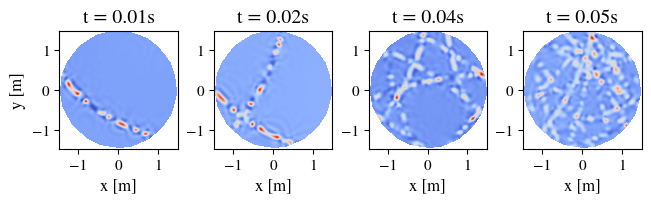

In [207]:
rirdata = data['reference_data']
fs = data['fs']
grid = data['grid_reference']
t_test1 = int(fs*0.015)
t_test2 = int(fs*0.02)
t_test3 = int(fs*0.035)
t_test4 = int(fs*0.05)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1, _ = plot_sf(rirdata[:, t_test1], grid[0], grid[1], ax = ax1, name = 't = {:.2f}s'.format(t_test1/fs))
ax2, _ = plot_sf(rirdata[:, t_test2], grid[0], grid[1], ax = ax2,  name = 't = {:.2f}s'.format(t_test2/fs))
ax3, _ = plot_sf(rirdata[:, t_test3], grid[0], grid[1], ax = ax3,  name = 't = {:.2f}s'.format(t_test3/fs))
ax4, _ = plot_sf(rirdata[:, t_test4], grid[0], grid[1], ax = ax4,  name = 't = {:.2f}s'.format(t_test4/fs))
for ax in (ax2, ax3, ax4):
    ax.set_ylabel('')
fig.show()

/var/folders/7f/_3r2l49x0ml1dqnf75pb0slm0000gp/T/ipykernel_32136/2595049687.py:5: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


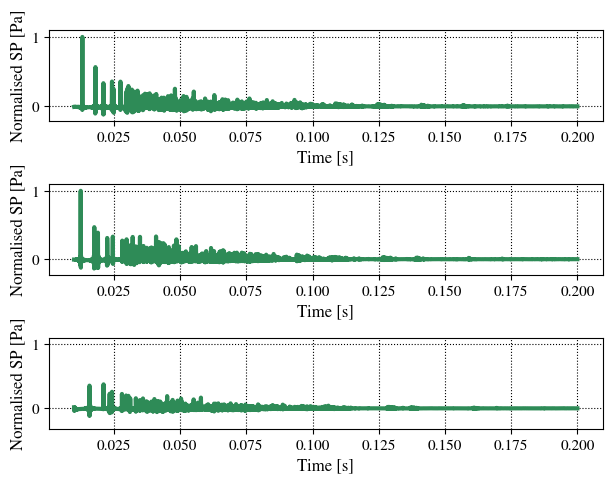

In [208]:
fig, ax = plt.subplots(3, 1)
ax[0] = plot_rir(rirdata[4], ax = ax[0])
ax[1] = plot_rir(rirdata[254], ax = ax[1])
ax[2] = plot_rir(rirdata[888], ax = ax[2])
fig.tight_layout()
plt.show()

## Prepare Data

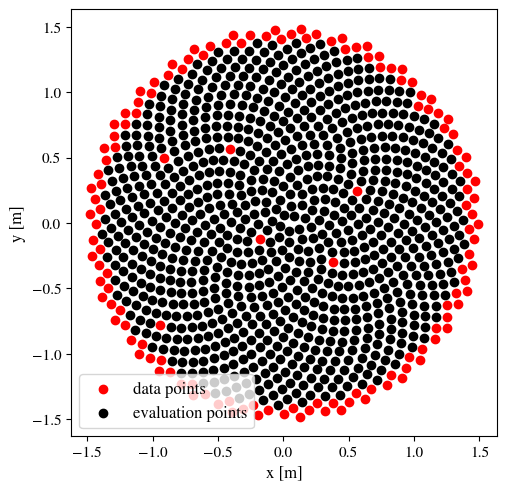

In [209]:
data = rirdata[:, :int(0.25*fs)] # truncate
t = np.linspace(0, 0.25, int(0.25*fs)) # Does not need normalisation if < 1 second
t_ind = np.arange(0, int(0.25*fs))
x_true = grid[0]
y_true = grid[1]
# boundary indices
boundary_ind = np.argwhere(x_true**2 + y_true**2 > (1.4)**2)
# regular point indices
mask = np.ones(grid.shape[1], dtype=bool)
mask[boundary_ind] = False
reg_ind = np.argwhere(mask == True)
# random interpolation indices
interp_indx = np.random.choice(reg_ind.squeeze(-1), 7, replace=False)# Randomly chosen points for Interior
# add to boundary indices
data_ind = np.vstack((boundary_ind, interp_indx[..., None])).squeeze(-1)
# regular point grid
mask = np.ones(grid.shape[1], dtype=bool)
mask[data_ind] = False
grid_rest = grid[:, mask]
# plot data points (spatial data points only e.g. not regarding time)
plt.scatter(grid[0, data_ind], grid[1, data_ind], color = 'red')
plt.scatter(grid_rest[0], grid_rest[1], color = 'k')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(['data points', 'evaluation points'])
plt.gca().set_aspect('equal')
plt.show()

## Training Data

In [210]:
total_points=len(x_true)*len(y_true)*len(t)
total_training_points =len(x_true[data_ind])*len(y_true[data_ind])*len(t)
total_bc_points =len(x_true[boundary_ind])*len(y_true[boundary_ind])*len(t)
print("We have",total_points,"points in total. We will select",total_training_points,"points to train our model (data term) and",total_bc_points,"for the boundary condition enforcement.")

We have 4000000000 points in total. We will select 73984000 points to train our model (data term) and 66564000 for the boundary condition enforcement.


In [219]:
dataset = PINNDataset(data, x_true, y_true, t, data_ind, boundary_ind, t_ind, device= device)
batch_size = 30
train_dataloader = DataLoader(dataset, batch_size= batch_size, shuffle = True)

In [134]:
data_dict = next(iter(train_dataloader))

In [135]:
data_dict['pressure_batch'].shape

torch.Size([30, 136])

# Train Neural Network

In [106]:
f_hat = torch.zeros(batch_size,1).to(device)

# Tuning Parameters

In [235]:
steps=20000
lr=1e-1
layers = np.array([3,20,20,20,20,20,20,20,20,1]) #8 hidden layers

In [239]:
PINN = FCN(layers, bounds = [1.6, 1.])

params = list(PINN.dnn.parameters())

'''Optimization'''

# 'L-BFGS Optimizer'
# optimizer = torch.optim.LBFGS(params, lr,
#                               max_iter = steps,
#                               max_eval = None,
#                               tolerance_grad = 1e-11,
#                               tolerance_change = 1e-11,
#                               history_size = 100,
#                               line_search_fn = 'strong_wolfe')
optimizer = torch.optim.Adam(params, lr)
'Neural Network Summary'
print(PINN.dnn)

DNN(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [ ]:
# time = time.time()
for batch in train_dataloader:
    train_input = batch['collocation_train']
    test_input = batch['collocation_all']
    p_train = batch['pressure_batch']
    p_test = batch['pressure_all']

    PINN.SGD_step(train_input, test_input, p_train, p_test)


elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))


''' Model Accuracy '''
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))



/Users/xen/miniconda3/envs/DSC_project/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30, 1, 136])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# Plots

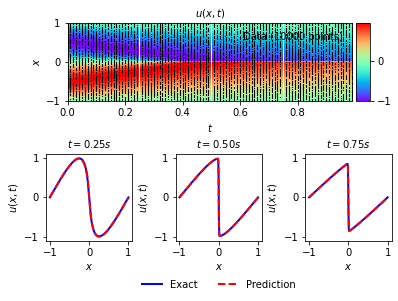

In [ ]:
solutionplot(u_pred,X_train_Nu.cpu().detach().numpy(),U_train_Nu)

In [ ]:
x1=X_true[:,0]
t1=X_true[:,1]

In [ ]:
arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()

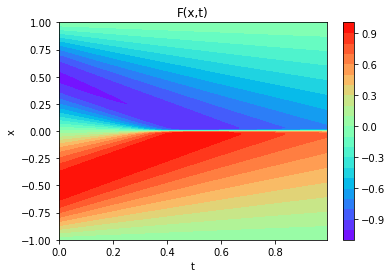

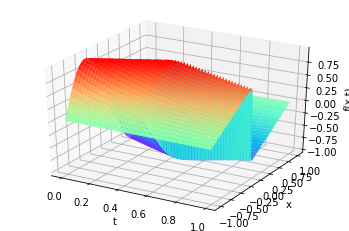

In [ ]:
plot3D_Matrix(arr_x1,arr_T1,torch.from_numpy(u_pred))

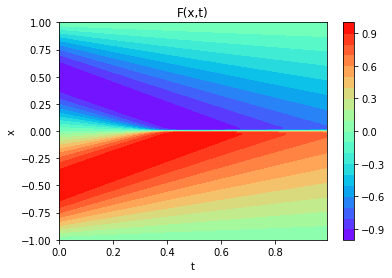

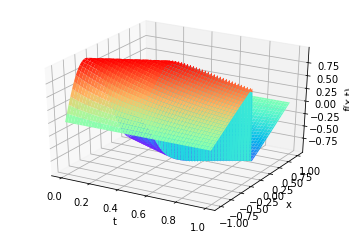

In [ ]:
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol)) 

## References:


[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations. arXiv preprint arXiv:1711.10561. http://arxiv.org/pdf/1711.10561v1

[2] Lu, L., Meng, X., Mao, Z., & Karniadakis, G. E. (1907). DeepXDE: A deep learning library for solving differential equations,(2019). URL http://arxiv. org/abs/1907.04502. https://arxiv.org/abs/1907.04502

[3] Rackauckas Chris, Introduction to Scientific Machine Learning through Physics-Informed Neural Networks. https://book.sciml.ai/notes/03/

[4] Repository: Physics-Informed-Neural-Networks (PINNs).https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation

[5]  Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics Informed Deep Learning (part ii): Data-driven Discovery of Nonlinear Partial Differential Equations. arXiv preprint arXiv:1711.10566. https://arxiv.org/abs/1711.10566

[6] Repository: PPhysics-Informed Deep Learning and its Application in Computational Solid and Fluid Mechanics.https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics.

